In [73]:
import sys
if '/home/rossco/immunova' not in sys.path:
    sys.path.append('/home/rossco/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating
from immunova.flow.gating.transforms import apply_transform
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.flow.gating.utilities import centroid, multi_centroid_calculation
from immunova.flow.plotting.static_plots import Plot
from immunova.data.mongo_setup import test_init
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN, KMeans
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import cycle
from datetime import datetime
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import pymongo
import pandas as pd
import numpy as np
import functools
import warnings
import os
warnings.filterwarnings('ignore')
test_init()

In [74]:
exp = FCSExperiment.objects(experiment_id='ILTIS_T1').get()

In [75]:
samples = exp.list_samples()
samples = [x for x in samples if 'hc' not in x]

<h1>Visualising functions</h1>

In [76]:
def visualise_manual_ellipse(hc, x, y, parent, transform, centroid, width, height, angle, xlim, ylim):
    data = hc.get_population_df(parent, transform=transform, transform_features=[x, y])
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    ellipse = Ellipse(xy=centroid, width=width, height=height,
                              angle=angle, fill=False, edgecolor='r')
    ax.add_patch(ellipse)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()
    
def visualise_manual_threshold(sample_go, parent_population, x, t, transform, xlim, ylim):
    data = sample_go.get_population_df(parent_population, transform=transform, transform_features=[x]).copy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data['SSC-A'], bins=500, norm=LogNorm())
    ax.axvline(t, c='r')
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    fig.show()
    
def visualise_manual_rect(sample_go, parent_population, x, y, x_min, x_max, y_min, y_max, xlim, ylim,
                         transform):
    data = sample_go.get_population_df(parent_population, transform=transform, transform_features=[x, y]).copy()
    fig, ax = plt.subplots(figsize=(5,5))
    ax.hist2d(data[x], data[y], bins=500, norm=LogNorm())
    r = Rectangle(xy=(x_min, y_min), width=x_max, height=y_max, fill=False, edgecolor='r')
    ax.add_patch(r)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.show()

<h2>Load data</h2>

In [77]:
sep = Gating(exp, 'sep6')

<h2>Debris gate</h2>

In [78]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

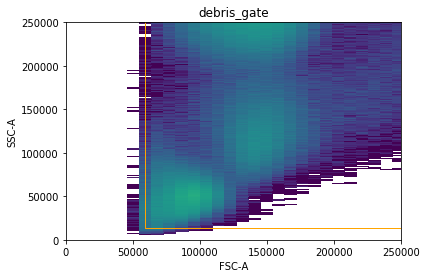

In [79]:
gate_definition = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, bottom_cutoff=0.001)
sep.create_gate(gate_name='debris_gate', parent='root', class_='Static', method='border_gate',
                kwargs=gate_definition, child_populations=child_populations)
sep.apply('debris_gate')

<h2>Lymph</h2>

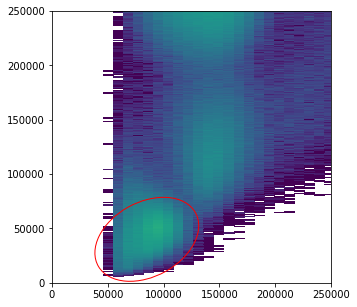

In [80]:
centroid=(85000, 40000)
width=100000
height=68000
angle=30
visualise_manual_ellipse(sep, 'FSC-A', 'SSC-A', 'root', False, 
                         centroid, width, height, angle, xlim=(0, 250000), ylim=(0,250000))

In [81]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_lymphocytes', definition='+')
child_populations.add_population('manual_lymphocytes_NEG', definition='-')

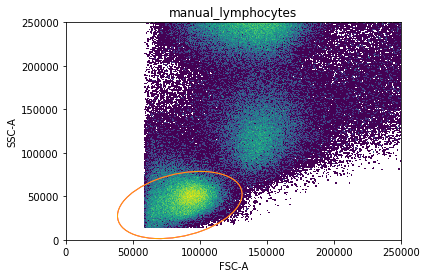

In [82]:
gate_definition = dict(x='FSC-A', y='SSC-A', centroid=centroid, width=width, height=height, angle=angle,
                      transform_x=None, transform_y=None)
sep.create_gate(gate_name='manual_lymphocytes', parent='cells', class_='Static', method='ellipse_gate',
                kwargs=gate_definition, child_populations=child_populations)
sep.apply('manual_lymphocytes')

<h2>Live CD3</h2>

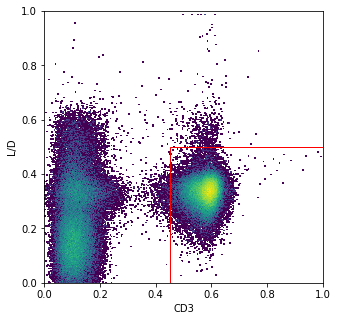

In [83]:
x_min, x_max, y_min, y_max = 0.45, 1.0, 0, 0.5
visualise_manual_rect(sep, 'manual_lymphocytes', 'CD3', 'L/D', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

In [84]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_liveCD3', definition='+')
child_populations.add_population('manual_dead', definition='-')

gate_definition = dict(x='CD3', y='L/D', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
sep.create_gate(gate_name='manual_liveCD3', parent='manual_lymphocytes', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

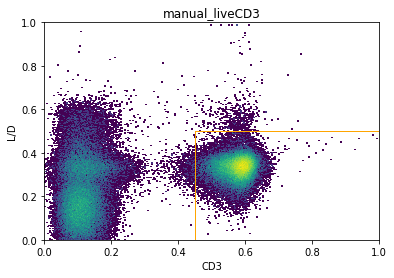

In [85]:
sep.apply('manual_liveCD3')

<h2>GDT</h2>

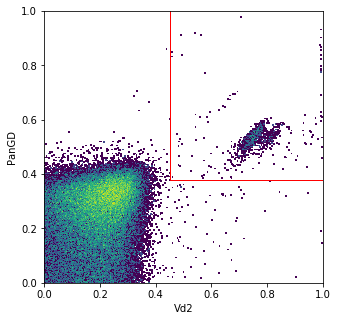

In [86]:
x_min, x_max, y_min, y_max = 0.45, 1.0, 0.38, 1
visualise_manual_rect(sep, 'manual_liveCD3', 'Vd2', 'PanGD', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

In [87]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_gdt', definition='+')
child_populations.add_population('manual_nongdt', definition='-')

gate_definition = dict(x='Vd2', y='PanGD', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
sep.create_gate(gate_name='manual_gdt', parent='manual_liveCD3', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

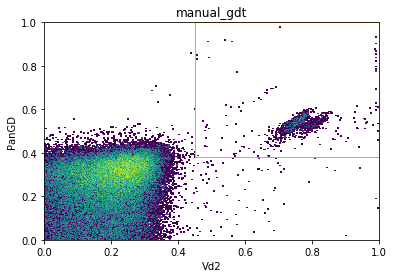

In [88]:
sep.apply('manual_gdt')

<h2>MAIT</h2>

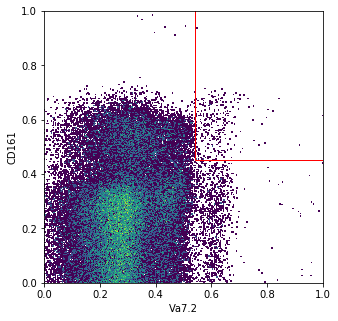

In [89]:
x_min, x_max, y_min, y_max = 0.54, 1.0, 0.45, 1
visualise_manual_rect(sep, 'manual_nongdt', 'Va7.2', 'CD161', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

In [90]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('manual_mait', definition='+')
child_populations.add_population('manual_classic', definition='-')

gate_definition = dict(x='Va7.2', y='CD161', x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
sep.create_gate(gate_name='manual_mait', parent='manual_nongdt', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

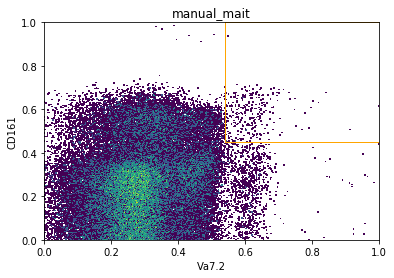

In [91]:
sep.apply('manual_mait')

<h2>CD4 CD8</h2>

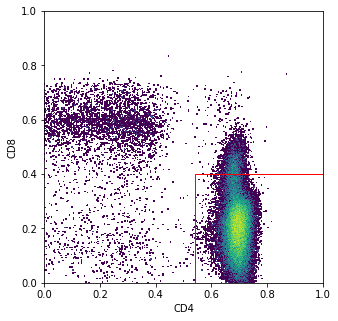

In [92]:
x_min, x_max, y_min, y_max = 0.54, 1.0, 0, 0.4
visualise_manual_rect(sep, 'manual_classic', 'CD4', 'CD8', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

In [93]:
child_populations = ChildPopulationCollection('threshold_2d')
child_populations.add_population('manual_cd4', definition=['+-'])
child_populations.add_population('manual_cd8', definition=['-+'])
child_populations.add_population('manual_other', definition=['++', '--'])

gate_definition = dict(x='CD4', y='CD8', threshold_x=0.42, threshold_y=0.4)
sep.create_gate(gate_name='manual_cd4cd8', parent='manual_classic', class_='Static', method='threshold_2d',
                kwargs=gate_definition, child_populations=child_populations)

True

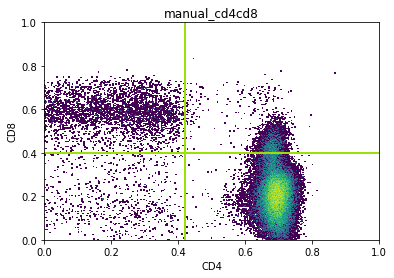

In [94]:
sep.apply('manual_cd4cd8')

<h2>CD4 maturation subsets FMO gate</h2>

In [ ]:
cd27 = sep.get_fmo_data(fmo='sep6_CD27', target_population='manual_cd4')
cd27 = sep.get_fmo_data(fmo='sep6_CD27', target_population='manual_cd4')

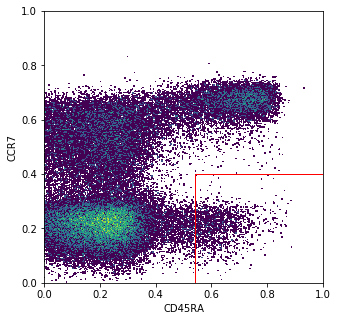

In [111]:
x_min, x_max, y_min, y_max = 0.54, 1.0, 0, 0.4
visualise_manual_rect(sep, 'manual_cd4', 'CD45RA', 'CCR7', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

<h1>Sidenote: Evidence of working FMO upgating</h1>

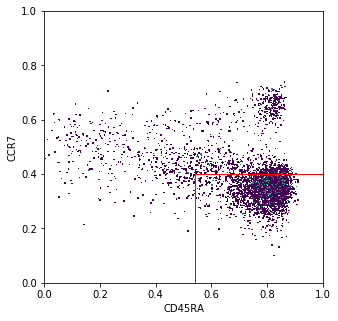

In [23]:
x_min, x_max, y_min, y_max = 0.54, 1.0, 0, 0.4
visualise_manual_rect(sep, 'manual_cd8', 'CD45RA', 'CCR7', x_min, x_max, y_min, y_max, 
                      xlim=(0,1), ylim=(0,1), transform=True)

In [24]:
sep.fmo_search_cache['sep6_CD27'].keys()

dict_keys(['root'])

In [107]:
sep.save()

Saved successfully!


True

In [25]:
cd27 = sep.get_fmo_data('manual_cd8', 'sep6_CD27')

In [27]:
sep.data.shape

(1004938, 19)

In [26]:
cd27.shape

(531896, 19)

Starting at 2019-11-02 19:13:56.989581
0.000437: Estimating cells...
30.134831: Estimating manual_lymphocytes...
45.340895: Estimating manual_liveCD3...
51.050916: Estimating manual_nongdt...
54.492062: Estimating manual_classic...
57.540164: Estimating manual_cd8...
Processng time: 60.931131


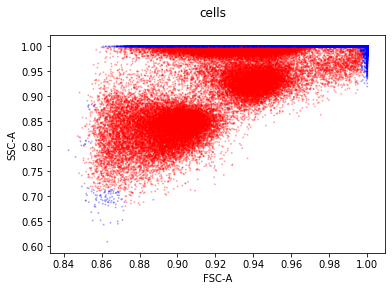

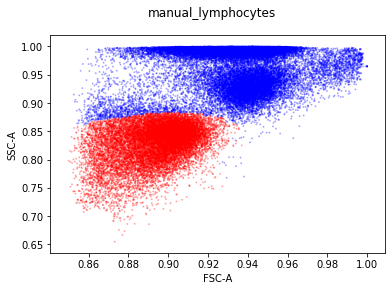

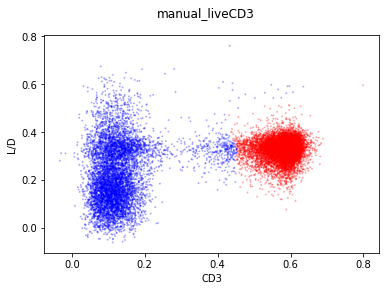

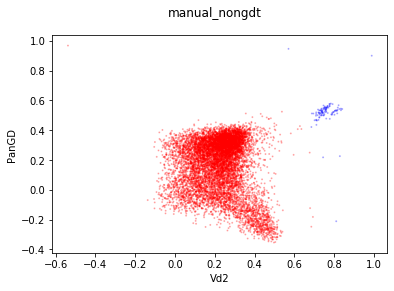

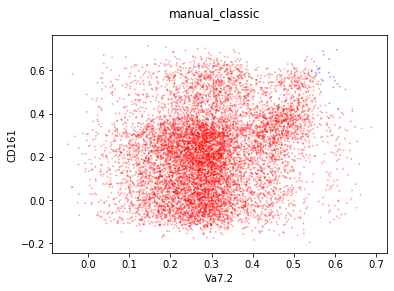

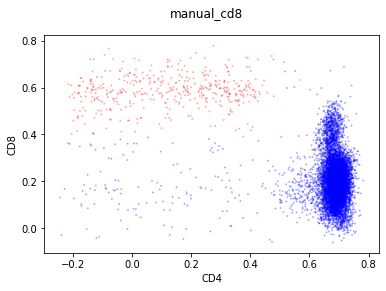

In [109]:
from sklearn.neighbors import KNeighborsClassifier
from immunova.flow.gating.transforms import apply_transform
from datetime import datetime
def search_fmo_cache(sep, target_population, fmo):
    if target_population in sep.fmo_search_cache[fmo].keys():
        return sep.fmo_search_cache[fmo][target_population]
    return None

target_population = 'manual_cd8'
fmo = 'sep6_CD27'
cache_idx = sep.search_fmo_cache(target_population, fmo)
if cache_idx is not None:
    print(sep.fmo[fmo].loc[cache_idx])
else:
    cache_idx = sep.fmo_search_cache[fmo]['root']

root = sep.populations['root']
node = sep.populations[target_population]
route = [x.name for x in node.path]
start = datetime.now()
print(f'Starting at {start}')
for pop in route[1:]:
    s = datetime.now()
    print(f'{(s-start).total_seconds()}: Estimating {pop}...')
    fmo_data = sep.fmo[fmo].loc[cache_idx]
    
    # Train KNN from whole panel data
    x = sep.populations[pop].geom['x']
    y = sep.populations[pop].geom['y'] or 'FSC-A'
    parent = sep.populations[pop].parent.name
    train = sep.get_population_df(parent)[[x, y]].copy()
    train['pos'] = 0
    if train.shape[0] > 10000:
        train = train.sample(10000)
    train.pos = train.pos.mask(train.index.isin(sep.populations[pop].index), 1)
    y_ = train.pos.values
    knn = KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree', n_neighbors=5)
    knn.fit(train[[x,y]], y_)
    
    # Predict FMO 
    y_hat = knn.predict(fmo_data[[x, y]])
    fmo_data['pos'] = y_hat
    cache_idx = fmo_data[fmo_data['pos'] == 1].index.values
    fig, ax = plt.subplots()
    s = fmo_data.sample(frac=0.2)
    def colour(x):
        if x == 1:
            return 'red'
        return 'blue'
    s = apply_transform(s, [x, y], 'logicle')
    ax.scatter(s[x], s[y], s=1, alpha=0.25, c=s['pos'].apply(lambda x: colour(x)))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.suptitle(pop)
    fig.show()
    
fmo_data = fmo_data.loc[cache_idx]
end = datetime.now()
print(f'Processng time: {(end-start).total_seconds()}')

In [141]:
route = ['root',
 'cells',
 'manual_lymphocytes',
 'manual_liveCD3',
 'manual_nongdt',
 'manual_classic',
 'manual_cd8']

In [148]:
x = 'manual_liveCD3'
for i, t in enumerate(route[::-1]):
    if x == t:
        print(route[::-1][:i+1][::-1])
        break

['manual_liveCD3', 'manual_nongdt', 'manual_classic', 'manual_cd8']


In [146]:
route[::-1][::-1]

['root',
 'cells',
 'manual_lymphocytes',
 'manual_liveCD3',
 'manual_nongdt',
 'manual_classic',
 'manual_cd8']